注意：

  UHF 采样率在439.5k时，是连续采样

In [1]:
import visa
import zhinst.utils
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from scipy.optimize import curve_fit
from scipy import signal
from scipy import integrate
from scipy.integrate import simps
#from __future__ import print_function

# UHF

In [2]:
device_id    = 'dev2374'
apilevel     = 6
(daq, device, _) = zhinst.utils.create_api_session(device_id, apilevel)
_=zhinst.utils.disable_everything(daq, device)

Discovered device `dev2374`: UHFLI with options .
Creating an API session for device `dev2374` on `127.0.0.1`, `8004` with apilevel `6`.


In [3]:
def ziDAQ(double_or_int, path, value):
    if (double_or_int == 'setDouble'): daq.setDouble(path, value)
    if (double_or_int == 'setInt'):    daq.setDouble(path, value)

### Input Channel Setting

In [4]:
#input channel
ziDAQ('setInt', '/dev2374/sigins/0/imp50', 1)
ziDAQ('setInt', '/dev2374/sigins/0/ac', 0)
ziDAQ('setInt', '/dev2374/sigins/0/autorange', 1)

#lockin channel
ziDAQ('setInt', '/dev2374/demods/0/order', 4)
ziDAQ('setDouble', '/dev2374/demods/0/timeconstant', 6.92291283e-06)

#data transfer
ziDAQ('setInt', '/dev2374/demods/0/enable', 1);
ziDAQ('setDouble', '/dev2374/demods/0/rate', 439.5e3)

In [5]:
def readBiChannelXY_func(timeLength=1, LPF=False):
    # Unsubscribe any streaming data.
    daq.unsubscribe('*')

    # Perform a global synchronisation between the device and the data server:
    # Ensure that 1. the settings have taken effect on the device before issuing
    # the poll() command and 2. clear the API's data buffers. Note: the sync()
    # must be issued after waiting for the demodulator filter to settle above.
    daq.sync()

    # Subscribe to the demodulator's sample node path.
    path1 = '/dev2374/demods/0/sample'
    daq.subscribe(path1) #UHF的DEMOD0从这里开始记录数据 
    
    #poll data
    # Poll the subscribed data from the data server. Poll will block and record
    # for poll_length seconds.
    poll_length = timeLength  # [s]
    poll_timeout = 500  # [ms]
    poll_flags = 0
    poll_return_flat_dict = True

    sample = daq.poll(poll_length, poll_timeout, poll_flags, poll_return_flat_dict)
    
    # Unsubscribe from all paths.
    daq.unsubscribe('*')
    
    #data
    X1_vec  = sample[path1]['x']*np.sqrt(2) 
    Y1_vec  = sample[path1]['y']*np.sqrt(2)
    timestamp1 = sample[path1]['timestamp']
        
    #时间坐标
    timestamp0 = timestamp1[0]
    clockbase  = float(daq.getInt('/dev2374/clockbase'))
    t1_vec     = (timestamp1 - timestamp0)/clockbase

    return [t1_vec, X1_vec, Y1_vec]

### Scope

In [23]:
#=========================================================
#setting
scope_length = 2**16
scope_time   = 9
in_channel   = 1

# Configure the scope and obtain data with triggering disabled.
daq.setInt('/dev2374/scopes/0/length', scope_length)
daq.setInt('/dev2374/scopes/0/channel', in_channel)
daq.setInt('/dev2374/scopes/0/channels/%d/bwlimit'%in_channel, 1)
daq.setInt('/dev2374/scopes/0/channels/%d/inputselect'%in_channel, in_channel)
daq.setInt('/dev2374/scopes/0/single', 1)
daq.setInt('/dev2374/scopes/0/time', scope_time)
daq.setInt('/dev2374/scopes/0/segments/count', 1)
#trigger
daq.setInt('/dev2374/scopes/0/trigenable', 0)
daq.setDouble('/dev2374/scopes/0/trigholdoff', 0.050)
daq.setInt('/dev2374/scopes/0/segments/enable', 0)
daq.sync()

# Now initialize and configure the Scope Module.
scopeModule = daq.scopeModule()
scopeModule.set('mode', 1)
scopeModule.set('averager/weight', 1) #   weight=1 - don't average.
scopeModule.set('historylength', 1)
scopeModule.subscribe('/dev2374/scopes/0/wave')

In [24]:
def readScope_func(in_channel=0):
    ziDAQ('setInt', '/dev2374/scopes/0/channels/0/inputselect', in_channel)
    time.sleep(0.1)
    
    #==========================================================================
    #zhinst.utils.sigin_autorange(daq, device, in_channel) #调整输入端的range（ADC前的放大器）
    # Tell the module to be ready to acquire data; reset the module's progress to 0.0.
    scopeModule.execute()

    # Enable the scope: Now the scope is ready to record data upon receiving triggers.
    daq.setInt('/%s/scopes/0/enable' % device, 1)
    daq.sync()

    start = time.time()
    timeout = 5  # [s]
    records = 0
    # Wait until the Scope Module has received and processed the desired number of records.
    while (records < 1):
        time.sleep(0.1)
        records = scopeModule.getInt("records")
        #progress = scopeModule.progress()[0]
        if (time.time() - start) > timeout:
            print("\nTimeout!\n")
            break    

    # Stop the module; to use it again we need to call execute().
    scopeModule.finish()  #在读取数据前停止module，防止继续读取数据

    # Read out the scope data from the module.
    daq.setInt('/%s/scopes/0/enable' % device, 0)


    data_return = scopeModule.read(True)['/dev2374/scopes/0/wave']
    voltage_vec = data_return[0][0]['wave'][0]
    delta_t     = data_return[0][0]['dt']
    t_vec       = delta_t*np.arange(0,len(voltage_vec))
    return [t_vec, voltage_vec]

# Measured by UHF-Scope

In [25]:
def noiseSpectrum_func(t_vec, voltage_vec):
    tf = t_vec[-1]-t_vec[0]
    freq_vec        = 1/tf*np.arange(1,t_vec.size//2+1)
    voltageFreq_vec = np.fft.fft(voltage_vec)[1:(t_vec.size//2+1)]
    noiseSpectrum   = 2*np.abs(voltageFreq_vec)**2*tf/t_vec.size**2
    return [freq_vec, noiseSpectrum]

In [26]:
noise_vec = np.zeros(scope_length//2)
N_exp     = 1000

for n in tqdm(range(N_exp)):
    [t_vec, voltage_vec] = readScope_func(in_channel=0)
    [freq_vec, noise_temp] = noiseSpectrum_func(t_vec, voltage_vec)
    noise_vec = noise_vec + noise_temp / N_exp

100%|███████████████████████████████████████| 1000/1000 [04:36<00:00,  3.64it/s]


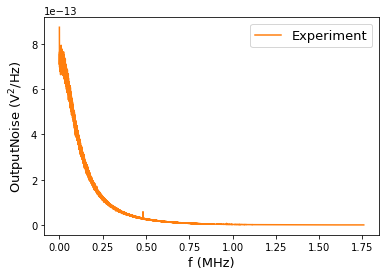

In [27]:
%matplotlib inline

plt.plot(freq_vec/1e6, noise_vec, c='C1', label='Experiment')
#plt.xlim([0, 800])
#plt.ylim([0, 3e-15])
plt.ylabel(r'$\rm OutputNoise\  (V^2/Hz)$', fontsize=13)
plt.xlabel('f (MHz)', fontsize=13)
plt.legend(fontsize=13)

plt.savefig("OutputNoise_byScope.png", format='png', dpi=200)

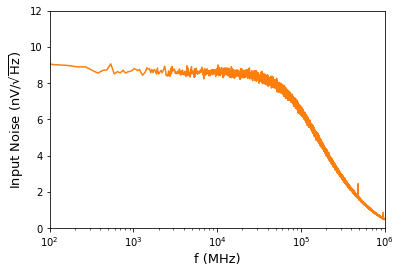

In [31]:
%matplotlib inline

Gain = 99
plt.plot(freq_vec, np.sqrt(noise_vec/Gain**2)*1e9, c='C1')
plt.ylim([0, 12])
plt.ylabel(r'$\rm Input\ Noise\  (nV / \sqrt{Hz})$', fontsize=13)
plt.xlabel('f (MHz)', fontsize=13)
plt.xscale('log')
plt.xlim([100, 1e6])


plt.savefig("InputNoise_byScope.png", format='png', dpi=200)